Using device: cpu
Dataset already exists.
Training samples: 11428
Validation samples: 2858
Testing Your Efficient Architecture Implementation

1. Testing DepthwiseSeparableConv...
   Input shape: torch.Size([1, 32, 56, 56])
   Output shape: torch.Size([1, 64, 56, 56])
   ✓ DepthwiseSeparableConv working!

2. Testing InvertedResidual...
   Input shape: torch.Size([1, 32, 56, 56])
   Output shape: torch.Size([1, 32, 56, 56])
   ✓ InvertedResidual working!

3. Testing MobileNetV2...
   Input shape: torch.Size([1, 3, 224, 224])
   Output shape: torch.Size([1, 18])
   Total parameters: 2,246,930
   Trainable parameters: 2,246,930
   Model size: 8.70 MB
   ✓ MobileNetV2 working!

Model Comparison
Your MobileNetV2    : 2.25M params, 8.70 MB
ResNet18            : 11.19M params, 42.71 MB
Pretrained MobileNetV2: 2.25M params, 8.70 MB


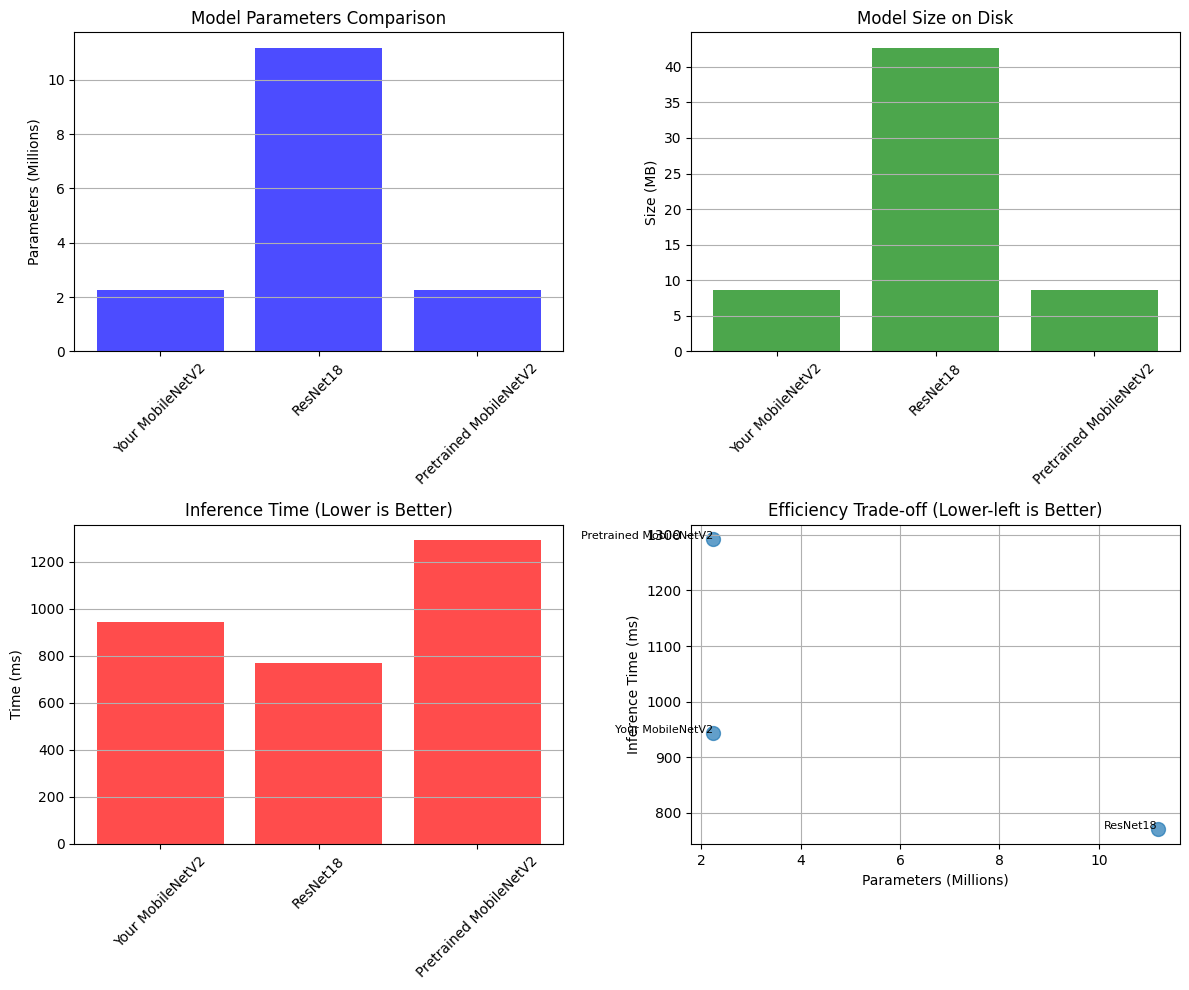


Training Your MobileNetV2


Do you want to train your MobileNetV2? (y/n):  y



Epoch 1/5
------------------------------


Training:   6%|▌         | 21/358 [00:45<09:46,  1.74s/it, loss=2.78, acc=14.4] 

In [ ]:
"""
Assignment Extension: Memory-Efficient Architectures for Edge Deployment
========================================================================
Learning Objectives:
1. Implement depthwise separable convolutions (MobileNet)
2. Build inverted residual blocks (MobileNetV2)
3. Understand FLOPs vs parameters vs memory trade-offs
4. Design models for memory-constrained devices

Total Points: 20
- Depthwise Separable Conv implementation (5 pts)
- Inverted Residual Block implementation (5 pts)
- MobileNetV2 architecture (5 pts)
- Model efficiency analysis (5 pts)

IMPORTANT CONCEPTS:
- FLOPs (Floating Point Operations): Measure of computational cost
  Standard Conv: FLOPs = 2 × H × W × K² × C_in × C_out
  Depthwise Conv: FLOPs = 2 × H × W × K² × C_in
  Pointwise Conv: FLOPs = 2 × H × W × C_in × C_out

- Parameters: Number of trainable weights
  Standard Conv: params = K² × C_in × C_out + C_out (bias)
  Depthwise: params = K² × C_in + C_in
  Pointwise: params = C_in × C_out + C_out

- Memory: Storage needed for model weights (typically 4 bytes per float32 param)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import zipfile
import urllib.request
from tqdm import tqdm
import time

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Download dataset function
def download_dataset():
    """Download and extract the UVA landmarks dataset."""
    url = "https://firebasestorage.googleapis.com/v0/b/uva-landmark-images.appspot.com/o/dataset.zip?alt=media&token=e1403951-30d6-42b8-ba4e-394af1a2ddb7"

    if not os.path.exists('dataset'):
        print("Downloading dataset...")
        urllib.request.urlretrieve(url, 'dataset.zip')
        print("Extracting dataset...")
        with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
        os.remove('dataset.zip')
    else:
        print("Dataset already exists.")

download_dataset()

# Dataset parameters
data_dir = "dataset/"
batch_size = 32
img_size = 224  # MobileNet/EfficientNet use 224x224
num_classes = 18

# Data transforms
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
full_dataset = datasets.ImageFolder(data_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")



class ConvBNReLU(nn.Sequential):
    """
    The atomic unit of modern CNNs. This replaced Conv→ReLU after 2015.
    This is used EVERYWHERE - VGG, ResNet,
    MobileNet, EfficientNet. It's not just a pattern, it's THE pattern.
    """
    def __init__(self, c_in, c_out, kernel_size=3, stride=1, padding=1):
        super().__init__(
            # Key insight: bias=False because BN (batchnorm) learns bias
            # No forward method needed since the convolution2d to batchnorm to ReLU does it itself.
            nn.Conv2d(c_in, c_out, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True)  # inplace saves memory
        )

# ============================================================================
# Part 1: Depthwise Separable Convolution (5 points)
# ============================================================================

class DepthwiseSeparableConv(nn.Module):
    """
    TODO (5 pts): Implement depthwise separable convolution as used in MobileNet.

    This replaces a standard convolution with two operations:
    1. Depthwise convolution: Apply a single filter per input channel
    2. Pointwise convolution: 1x1 conv to combine channels

    Design Requirements:
    - Depthwise: Conv2d with groups=in_channels (each filter operates on one channel)
    - Pointwise: Conv2d with kernel_size=1 (combines information across channels)
    - Use BatchNorm2d after each convolution
    - Use ReLU6 activation (clamps output between 0 and 6, better for quantization)
    - No bias in conv layers when using BatchNorm (bias=False)

    Efficiency Analysis:
    - Standard 3x3 conv: 9 × C_in × C_out parameters
    - Depthwise + Pointwise: 9 × C_in + C_in × C_out parameters
    - Reduction factor: approximately 8-9x for typical channel counts

    Example: C_in=128, C_out=128
    - Standard: 9 × 128 × 128 = 147,456 params
    - DW+PW: 9 × 128 + 128 × 128 = 17,536 params (8.4x reduction!)
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        
        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, stride = stride, kernel_size = 3, padding = 1, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
        
        # TODO: Implement depthwise convolution
        # Hint: Use groups=in_channels to make each filter operate on single channel
        # Structure: Conv2d -> BatchNorm2d -> ReLU6
        # Kernel size should be 3x3 with padding=1 to maintain spatial dimensions

        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        # TODO: Implement pointwise convolution
        # Hint: This is a 1x1 convolution that combines the depthwise outputs
        # Structure: Conv2d(kernel_size=1) -> BatchNorm2d -> ReLU6

        pass

    def forward(self, x):
        return self.pointwise(self.depthwise(x))
        
        # TODO: Apply depthwise then pointwise convolution
        # Return the final output
        pass

    
# ============================================================================
# Part 2: Inverted Residual Block (5 points)
# ============================================================================

class InvertedResidual(nn.Module):
    """
    TODO (5 pts): Implement the inverted residual block from MobileNetV2.

    Key Innovation: "Inverted" means we expand channels first, then compress
    Traditional residual: wide -> narrow -> wide
    Inverted residual: narrow -> wide -> narrow

    Architecture:
    1. Expansion layer: 1x1 conv to expand channels by expand_ratio
    2. Depthwise layer: 3x3 depthwise conv (may have stride for downsampling)
    3. Projection layer: 1x1 conv to project back to output channels
    4. Skip connection: Only when stride=1 AND in_channels=out_channels

    Design Requirements:
    - Expansion: Only if expand_ratio != 1 (skip if no expansion needed)
    - All layers use BatchNorm, but NO activation after final projection
    - Use ReLU6 for all activations except the last layer
    - hidden_dim = in_channels * expand_ratio

    Memory Optimization:
    - Linear bottleneck (no activation after projection) preserves information
    - Skip connection only when dimensions match (saves memory)

    FLOP Analysis for one block (H×W×C_in input):
    - Expansion: H×W×C_in×(expand_ratio×C_in) FLOPs
    - Depthwise: H×W×9×(expand_ratio×C_in) FLOPs
    - Projection: H×W×(expand_ratio×C_in)×C_out FLOPs
    """
    def __init__(self, in_channels, out_channels, stride=1, expand_ratio=6):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        hidden_dim = int(round(in_channels * expand_ratio))

        if (self.stride == 1) and (in_channels == out_channels):
            self.use_residual = True
        else:
            self.use_residual = False
        
        # TODO: Determine when to use residual connection
        # Residual only when: stride=1 AND in_channels=out_channels
        # Store as self.use_residual
        
        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNReLU(in_channels, hidden_dim, kernel_size = 1, padding = 0)) #drop padding to maintain dimensions
            
        layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, 
                                stride=self.stride, padding=1, groups=hidden_dim, bias = False))  
        layers.append(nn.BatchNorm2d(hidden_dim))
        layers.append(nn.ReLU6(inplace=True))
        
        layers.append(nn.Conv2d(hidden_dim, out_channels, kernel_size = 1, bias = False))
        layers.append(nn.BatchNorm2d(out_channels))
                          
        # TODO: Build the layers list
        # If expand_ratio != 1:
        #   Add expansion layer: Conv2d(kernel=1) -> BN -> ReLU6
        # Always add:
        #   Depthwise: Conv2d(kernel=3, stride=stride, groups=hidden_dim) -> BN -> ReLU6
        #   Projection: Conv2d(kernel=1) -> BN (NO activation here!)

        self.conv = nn.Sequential(*layers)
        
        # TODO: Combine layers into self.conv = nn.Sequential(*layers)
        pass

    def forward(self, x):
        out = self.conv(x)
        if self.use_residual == True:
            return x + out
        else:
            return out
                          
        # TODO: Implement forward pass
        # If self.use_residual is True: return x + self.conv(x)
        # Otherwise: return self.conv(x)
        pass


# ============================================================================
# Part 3: MobileNetV2 Architecture (5 points)
# ============================================================================

class MobileNetV2(nn.Module):
    """
    TODO (5 pts): Build a simplified MobileNetV2 architecture.

    Architecture Overview:
    1. Initial conv: 3 -> 32 channels, stride=2 (downsample to 112x112)
    2. Series of InvertedResidual blocks with specific configurations
    3. Final conv: expand to 1280 channels (wide feature layer)
    4. Global average pooling
    5. Classifier: Linear(1280, num_classes)

    Block Configuration:
    Each block has (in_channels, out_channels, stride, expand_ratio)
    - t=1: no expansion, t=6: 6x expansion
    - s=2: downsample spatial dimensions by 2

    Design Principles:
    - Width multiplier: Can scale all channels by a factor (0.5, 0.75, 1.0)
    - Resolution multiplier: Can use smaller input sizes (192, 160, 128)

    Memory Considerations:
    - Peak memory usage occurs at expansion layers
    - Skip connections don't add parameters but need memory for gradients
    - Total params ≈ 2.3M for width_mult=1.0 (vs ResNet50's 25M)

    Suggested Block Sequence (simplified):
    Stage 1: 32 -> 16, t=1, s=1
    Stage 2: 16 -> 24, t=6, s=2 (downsample)
             24 -> 24, t=6, s=1
    Stage 3: 24 -> 32, t=6, s=2 (downsample)
             32 -> 32, t=6, s=1 (repeat 2x)
    Stage 4: 32 -> 64, t=6, s=2 (downsample)
             64 -> 64, t=6, s=1 (repeat 3x)
    Stage 5: 64 -> 96, t=6, s=1 (repeat 3x)
    Stage 6: 96 -> 160, t=6, s=2 (downsample)
             160 -> 160, t=6, s=1 (repeat 2x)
    Stage 7: 160 -> 320, t=6, s=1
    """
    def __init__(self, num_classes=18, width_mult=1.0, dropout_prob=0.2):
        super(MobileNetV2, self).__init__()
        self.conv1 = ConvBNReLU(3, 32, kernel_size = 3, stride = 2, padding = 1)
                          
        # TODO: Build the initial convolution layer
        # Conv2d(3, 32, kernel=3, stride=2, padding=1) -> BN -> ReLU6
        # This reduces 224x224 to 112x112
        
        self.residualblock = nn.Sequential(
            # Stage 1: 32 -> 16, t=1, s=1 (no expansion, no downsample)
            self._make_stage(int(round(32 * width_mult)), int(round(16 * width_mult)), num_blocks=1, stride=1, expand_ratio=1),
            
            # Stage 2: 16 -> 24, downsample, then repeat
            self._make_stage(int(round(16 * width_mult)), int(round(24 * width_mult)), num_blocks=2, stride=2, expand_ratio=6),
            
            # Stage 3: 24 -> 32, downsample, then repeat 2x more (3 total)
            self._make_stage(int(round(24 * width_mult)), int(round(32 * width_mult)), num_blocks=3, stride=2, expand_ratio=6),
            
            # Stage 4: 32 -> 64, downsample, then repeat 3x more (4 total)
            self._make_stage(int(round(32 * width_mult)), int(round(64 * width_mult)), num_blocks=4, stride=2, expand_ratio=6),
            
            # Stage 5: 64 -> 96, no downsample with stride 1 for all, repeat 3x (3 total)
            self._make_stage(int(round(64 * width_mult)), int(round(96 * width_mult)), num_blocks=3, stride=1, expand_ratio=6),
            
            # Stage 6: 96 -> 160, downsample, then repeat 2x more (3 total)
            self._make_stage(int(round(96 * width_mult)), int(round(160 * width_mult)), num_blocks=3, stride=2, expand_ratio=6),
            
            # Stage 7: 160 -> 320, no downsample, single block
            self._make_stage(int(round(160 * width_mult)), int(round(320 * width_mult)), num_blocks=1, stride=1, expand_ratio=6)
        )
        
                                  
        # TODO: Build the InvertedResidual blocks
        # Create a nn.Sequential with all the blocks following the configuration above
        # Remember to apply width_mult to scale channel counts if needed

        self.conv2 = ConvBNReLU(int(round(320 * width_mult)), int(round(1280 * width_mult)), kernel_size = 1)
        
        # TODO: Build the final convolution layer
        # Conv2d(320, 1280, kernel=1) -> BN -> ReLU6
        # This creates a wide feature layer for better classification
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
                          
        # TODO: Add global average pooling
        # Use nn.AdaptiveAvgPool2d((1, 1)) to handle any input size
                          
        self.dropout = nn.Dropout(p = dropout_prob)
                          
        # TODO: Add dropout for regularization (optional but recommended)
        # nn.Dropout(p=dropout_prob) before the classifier
        last_channel = int(round(1280 * width_mult))
        self.fc = nn.Linear(last_channel, num_classes)
                          
        # TODO: Add the final classifier
        # nn.Linear(1280, num_classes)
                          
        self._initialize_weights()

        # TODO: Initialize weights properly
        # Call self._initialize_weights()
        pass

    def _make_stage(self, in_channels, out_channels, num_blocks, stride, expand_ratio):
        """
        Helper function to create a stage with multiple inverted residual blocks.
        """
        #Ensuring the in and out channels are ints
        in_channels = int(round(in_channels))
        out_channels = int(round(out_channels))
        # Create empty list to store all blocks
        blocks = []
        # Loop through and create each block
        for i in range(num_blocks):
            # Determine if this is the first block
            if i == 0:
                # First block: uses the given stride (may downsample)
                # Input channels = in_channels, output channels = out_channels
                blocks.append(InvertedResidual(in_channels=in_channels, out_channels=out_channels, 
                                   stride=stride, expand_ratio=expand_ratio))
            else:
                # Subsequent blocks: stride=1 (no downsampling)
                # Input channels = output channels (dimensions already match)
                # This enables residual connections for all subsequent blocks
                blocks.append(InvertedResidual(in_channels=out_channels, out_channels=out_channels, 
                                   stride=1, expand_ratio=expand_ratio))
        
        return nn.Sequential(*blocks)


    def forward(self, x):
        x = self.conv1(x)
        x = self.residualblock(x)
        x = self.conv2(x)
        x = self.avgpool(x).flatten(start_dim=1)
        x = self.dropout(x)
        return self.fc(x)
                          
        # TODO: Implement the forward pass
        # Pass through: features -> avgpool -> flatten -> dropout -> classifier
        pass

    def _initialize_weights(self):
        """Initialize model weights for better training."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)


# ============================================================================
# Part 4: Model Efficiency Analysis (5 points)
# ============================================================================

def count_parameters(model):
    """Count total and trainable parameters."""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

def get_model_size_mb(model):
    """Calculate model size in MB (assuming float32 weights)."""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()

    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / (1024 ** 2)
    return size_all_mb

def estimate_flops(model, input_shape=(1, 3, 224, 224)):
    """
    TODO (Bonus): Estimate FLOPs for your model.

    Simplified FLOP counting:
    - Conv2d: 2 × H_out × W_out × K² × C_in × C_out / groups
    - Linear: 2 × in_features × out_features
    - BatchNorm: 4 × num_features (can often ignore)

    This is complex to implement fully, so a simplified version is fine.
    You can also use existing libraries like thop or ptflops if available.
    """
    # Optional implementation
    total_flops = 0
    # Hint: You'd need to track input/output shapes through the network
                                    
    try:
        from thop import profile
        import torch
        
        # # Create dummy input testing
        # dummy_input = torch.randn(input_shape)
        
        # Calculate FLOPs
        total_flops, params = profile(model, inputs=(input_shape,), verbose=False)
        
        print(f"FLOPs: {flops/1e9:.2f} GFLOPs")
        print(f"Params: {params/1e6:.2f} M")
        
        return total_flops
        
    except ImportError:
        print("Install thop: pip install thop")
        return 0
                          

def measure_inference_time(model, input_shape=(1, 3, 224, 224), num_runs=100):
    """Measure average inference time in milliseconds."""
    model.eval()
    device = next(model.parameters()).device
    dummy_input = torch.randn(input_shape).to(device)

    # Warm up (important for accurate timing)
    for _ in range(10):
        with torch.no_grad():
            _ = model(dummy_input)

    # Synchronize if using CUDA
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    # Time the inference
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(dummy_input)

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    end_time = time.time()
    avg_time = (end_time - start_time) / num_runs * 1000  # Convert to ms
    return avg_time

# ============================================================================
# Training Functions (Provided - No TODO)
# ============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': running_loss / (progress_bar.n + 1),
            'acc': 100. * correct / total
        })

    return running_loss / len(dataloader), 100. * correct / total

def evaluate(model, dataloader, criterion, device):
    """Evaluate model on validation/test set."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(dataloader), 100. * correct / total

# ============================================================================
# Visualization Functions (Provided - No TODO)
# ============================================================================

def plot_model_comparison(models_dict):
    """Compare efficiency metrics of different models."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    model_names = list(models_dict.keys())
    params_list = []
    size_list = []
    time_list = []

    for name, model in models_dict.items():
        total_params, _ = count_parameters(model)
        params_list.append(total_params / 1e6)  # Convert to millions
        size_list.append(get_model_size_mb(model))
        time_list.append(measure_inference_time(model.to(device)))

    # Plot 1: Parameters
    axes[0, 0].bar(model_names, params_list, color='blue', alpha=0.7)
    axes[0, 0].set_ylabel('Parameters (Millions)')
    axes[0, 0].set_title('Model Parameters Comparison')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, axis='y')

    # Plot 2: Model Size
    axes[0, 1].bar(model_names, size_list, color='green', alpha=0.7)
    axes[0, 1].set_ylabel('Size (MB)')
    axes[0, 1].set_title('Model Size on Disk')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, axis='y')

    # Plot 3: Inference Time
    axes[1, 0].bar(model_names, time_list, color='red', alpha=0.7)
    axes[1, 0].set_ylabel('Time (ms)')
    axes[1, 0].set_title('Inference Time (Lower is Better)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, axis='y')

    # Plot 4: Efficiency Score
    axes[1, 1].scatter(params_list, time_list, s=100, alpha=0.7)
    for i, name in enumerate(model_names):
        axes[1, 1].annotate(name, (params_list[i], time_list[i]),
                           fontsize=8, ha='right')
    axes[1, 1].set_xlabel('Parameters (Millions)')
    axes[1, 1].set_ylabel('Inference Time (ms)')
    axes[1, 1].set_title('Efficiency Trade-off (Lower-left is Better)')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

def plot_training_curves(history):
    """Plot training and validation curves."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Loss curves
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Progress - Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Accuracy curves
    axes[1].plot(history['train_acc'], label='Train Acc')
    axes[1].plot(history['val_acc'], label='Val Acc')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title('Training Progress - Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# ============================================================================
# Main Execution - Test Your Implementation
# ============================================================================

if __name__ == "__main__":
    print("="*80)
    print("Testing Your Efficient Architecture Implementation")
    print("="*80)

    # Test your implementations
    try:
        # Test DepthwiseSeparableConv
        print("\n1. Testing DepthwiseSeparableConv...")
        dw_conv = DepthwiseSeparableConv(32, 64)
        test_input = torch.randn(1, 32, 56, 56)
        output = dw_conv(test_input)
        print(f"   Input shape: {test_input.shape}")
        print(f"   Output shape: {output.shape}")
        print(f"   ✓ DepthwiseSeparableConv working!")
    except Exception as e:
        print(f"   ✗ Error in DepthwiseSeparableConv: {e}")

    try:
        # Test InvertedResidual
        print("\n2. Testing InvertedResidual...")
        inv_res = InvertedResidual(32, 32, stride=1, expand_ratio=6)
        test_input = torch.randn(1, 32, 56, 56)
        output = inv_res(test_input)
        print(f"   Input shape: {test_input.shape}")
        print(f"   Output shape: {output.shape}")
        print(f"   ✓ InvertedResidual working!")
    except Exception as e:
        print(f"   ✗ Error in InvertedResidual: {e}")

    try:
        # Test MobileNetV2
        print("\n3. Testing MobileNetV2...")
        mobilenet = MobileNetV2(num_classes=num_classes)
        test_input = torch.randn(1, 3, 224, 224)
        output = mobilenet(test_input)
        print(f"   Input shape: {test_input.shape}")
        print(f"   Output shape: {output.shape}")

        # Analyze model
        total_params, trainable_params = count_parameters(mobilenet)
        model_size = get_model_size_mb(mobilenet)
        print(f"   Total parameters: {total_params:,}")
        print(f"   Trainable parameters: {trainable_params:,}")
        print(f"   Model size: {model_size:.2f} MB")
        print(f"   ✓ MobileNetV2 working!")

    except Exception as e:
        print(f"   ✗ Error in MobileNetV2: {e}")

    # Compare with other models
    print("\n" + "="*80)
    print("Model Comparison")
    print("="*80)

    try:
        # Create models for comparison
        models_to_compare = {
            'Your MobileNetV2': MobileNetV2(num_classes=num_classes),
            'ResNet18': models.resnet18(num_classes=num_classes),
            'Pretrained MobileNetV2': models.mobilenet_v2(weights=None, num_classes=num_classes)
        }

        # Compare models
        for name, model in models_to_compare.items():
            total_params, _ = count_parameters(model)
            size_mb = get_model_size_mb(model)
            print(f"{name:20s}: {total_params/1e6:.2f}M params, {size_mb:.2f} MB")

        # Visualize comparison
        plot_model_comparison(models_to_compare)

    except Exception as e:
        print(f"Error in model comparison: {e}")

    # Train your model (optional - takes time)
    print("\n" + "="*80)
    print("Training Your MobileNetV2")
    print("="*80)

    train_model = input("Do you want to train your MobileNetV2? (y/n): ")

    if train_model.lower() == 'y':
        try:
            model = MobileNetV2(num_classes=num_classes, dropout_prob=0.2)
            model = model.to(device)

            # Setup training
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

            # Training loop
            num_epochs = 5
            history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

            for epoch in range(num_epochs):
                print(f"\nEpoch {epoch+1}/{num_epochs}")
                print("-" * 30)

                train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
                val_loss, val_acc = evaluate(model, val_loader, criterion, device)

                history['train_loss'].append(train_loss)
                history['train_acc'].append(train_acc)
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)

                print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
                print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

                scheduler.step()

            # Plot training curves
            plot_training_curves(history)

            print(f"\nFinal Validation Accuracy: {history['val_acc'][-1]:.2f}%")

            # Success criteria
            if history['val_acc'][-1] > 80:
                print("✓ Great job! Your model achieves good accuracy while being efficient!")
            elif history['val_acc'][-1] > 70:
                print("✓ Good start! Try fine-tuning hyperparameters or training longer.")
            else:
                print("Keep working! Check your implementation and try different settings.")

        except Exception as e:
            print(f"Error during training: {e}")

    print("\n" + "="*80)
    print("Assignment Complete!")
    print("="*80)
    print("\nKey Takeaways:")
    print("1. Depthwise separable convolutions reduce parameters by ~8-9x")
    print("2. Inverted residuals with linear bottlenecks preserve information")
    print("3. MobileNetV2 achieves ResNet-level accuracy with 10x fewer parameters")
    print("4. Efficient models are crucial for edge deployment (phones, IoT, etc.)")
    print("="*80)